## Fixed Data:

In [3]:
# Progress Bar
pip install tqdm

SyntaxError: invalid syntax (4106085463.py, line 2)

In [6]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
from fredapi import Fred


API_KEY = '1vGb0FOsg2hEIGrEhpueLCcWd1Y'
FRED_API_KEY = 'b13a905b98b5dfc1f3910d6a0d875ae3'

rootUrl = 'https://api.glassnode.com'

symbolList = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL', 'BAND', 'BAT', 'BIX', 'BNT', 'BOND', 'BRD', 'BUSD', 'BZRX', 'CELR', 'CHSB', 'CND', 'COMP', 'CREAM', 'CRO', 'CRV', 'CVC', 'CVP', 'DAI', 'DDX', 'DENT', 'DGX', 'DHT', 'DMG', 'DODO', 'DOUGH', 'DRGN', 'ELF', 'ENG', 'ENJ', 'EURS', 'FET', 'FTT', 'FUN', 'GNO', 'GUSD', 'HEGIC', 'HOT', 'HPT', 'HT', 'HUSD', 'INDEX', 'KCS', 'LAMB', 'LBA', 'LDO', 'LEO', 'LINK', 'LOOM', 'LRC', 'MANA', 'MATIC',
              'MCB', 'MCO', 'MFT', 'MIR', 'MKR', 'MLN', 'MTA', 'MTL', 'MX', 'NDX', 'NEXO', 'NFTX', 'NMR', 'Nsure', 'OCEAN', 'OKB', 'OMG', 'PAY', 'PERP', 'PICKLE', 'PNK', 'PNT', 'POLY', 'POWR', 'PPT', 'QASH', 'QKC', 'QNT', 'RDN', 'REN', 'REP', 'RLC', 'ROOK', 'RPL', 'RSR', 'SAI', 'SAN', 'SNT', 'SNX', 'STAKE', 'STORJ', 'sUSD', 'SUSHI', 'TEL', 'TOP', 'UBT', 'UMA', 'UNI', 'USDC', 'USDK', 'USDP', 'USDT', 'UTK', 'VERI', 'WaBi', 'WAX', 'WBTC', 'WETH', 'wNXM', 'WTC', 'YAM', 'YFI', 'ZRX']

symbolListShort = ['BTC', 'ETH', 'LTC']

endPoints = {
    'Price': '/v1/metrics/market/price_usd_close',
    'MarketCap': '/v1/metrics/market/marketcap_usd',
    'TransactionCount': '/v1/metrics/transactions/count',
    'ActiveAddress': '/v1/metrics/addresses/active_count',
}

### <font color='black'> Risk-free rate

In [8]:
fred = Fred(api_key=FRED_API_KEY)
Risk_free_rate = fred.get_series('DGS1MO').to_frame().reset_index().rename(columns={'index':'Date', 
                                                                                    0:'RiskFree'})
Risk_free_rate['RiskFree']= Risk_free_rate['RiskFree'] / 100
Risk_free_rate = Risk_free_rate.set_index('Date')['RiskFree'].interpolate(method="linear")
#Risk_free_rate.to_csv('risk_free_rate_na.csv')


## Get Multiple Attributes for Multiple Coins:

In [9]:
def PullData(coin: str,
             feature: str):
    """This Method Pull Data According to Input Parameters(coin, feature)

    Args:
        coin (str): Name of a Coin. Like: "BTC"
        feature (str): Feature of a Coin. Like: "Price"

    Returns:
        data (pd.DataFrame): A DataFrame Contains Date and Feature of One Coin
    """
    print(f"Pulling {coin}'s {feature}")

    import requests

    # Assemble full request url and get responses:
    reqUrl = rootUrl + endPoints[feature]
    res = requests.get(reqUrl,
                       params={'a': coin,
                               'api_key': API_KEY,
                               'i': '1w'})
    data_raw = pd.read_json(res.text,
                            convert_dates=['t'])

    # Rename column "v" according to features
    data = data_raw.rename(columns={"v": f"{feature}",
                                    't': 'Date'})

    # Return a dataframe
    return data

In [10]:
# Effect:
PullData('BTC', 'Price').head()

Pulling BTC's Price


,Date,Price
0,2010-07-12,0.08584
1,2010-07-19,0.05050
2,2010-07-26,0.06110
3,2010-08-02,0.06090
4,2010-08-09,0.06529


In [11]:
def PullStart(coinList: list):
    """This Method Gets Features(Listed in "endPoints"(Constant)) of Coins(Listed in "coinList"(Method Parameter))

    Args:
        coinList (list): The List of Coins' Name

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Contains All Features of Listed Coin's
    """
    # Initialization
    from functools import reduce
    from tqdm import tqdm
    from fredapi import Fred

    colName = ["Date"]
    for key in endPoints.items():
        colName.append(key)
    fullFrame = pd.DataFrame(columns=colName.append("Asset"))

    # Pull Fred RiskFree
    fred = Fred(api_key=FRED_API_KEY)
    Risk_free_rate = fred.get_series('DGS1MO').to_frame().reset_index().rename(columns={'index': 'Date',
                                                                                        0: 'RiskFree'})
    Risk_free_rate['RiskFree'] = Risk_free_rate['RiskFree'] / 100

    # Data Pull
    for i in tqdm(coinList):
        print(f"Start Pulling {i}'s data:")

        # Preparation for merging
        frameName = f"{i}_Frames"
        locals()[frameName] = []

        # Get data
        for j in list(endPoints.keys()):
            locals()[frameName].append(PullData(i,
                                                j))

        # Merge 2-column dataframes to a single dataframe
        dfName = f"{i}_All"
        # Outer Merge Glassnode to Ensure Not Missing Any Values.
        # Left Merge Fred to ensure all the records in api stored.
        locals()[dfName] = reduce(lambda left, right:
                                  pd.merge(left, right,
                                           on='Date',
                                           how='outer'),
                                  locals()[frameName]).merge(Risk_free_rate,
                                                             how='left',
                                                             on='Date').sort_values(by=['Date'])
        locals()[dfName]['Asset'] = i

        # Merge All Coins into a single Dataframe
        fullFrame = pd.concat([fullFrame, locals()[dfName]],
                                     ignore_index=True)

        print(f"{i} data successfully pulled\n")
    print('All Frames Merged')
    print('\nALL DATA SUCCESSFULLY PULLED!')

    return fullFrame

In [12]:
# Effect:
df = PullStart(symbolListShort)
df

  0%|                                                     | 0/3 [00:00<?, ?it/s]

Start Pulling BTC's data:
Pulling BTC's Price
Pulling BTC's MarketCap
Pulling BTC's TransactionCount
Pulling BTC's ActiveAddress


 33%|███████████████                              | 1/3 [00:02<00:04,  2.26s/it]

BTC data successfully pulled

Start Pulling ETH's data:
Pulling ETH's Price
Pulling ETH's MarketCap
Pulling ETH's TransactionCount
Pulling ETH's ActiveAddress


 67%|██████████████████████████████               | 2/3 [00:04<00:02,  2.51s/it]

ETH data successfully pulled

Start Pulling LTC's data:
Pulling LTC's Price
Pulling LTC's MarketCap
Pulling LTC's TransactionCount
Pulling LTC's ActiveAddress


100%|█████████████████████████████████████████████| 3/3 [00:07<00:00,  2.48s/it]

LTC data successfully pulled

All Frames Merged

ALL DATA SUCCESSFULLY PULLED!


,Date,Price,MarketCap,TransactionCount,ActiveAddress,RiskFree,Asset
0,2008-12-29,NaN,NaN,NaN,0,0.0004,BTC
1,2009-01-05,NaN,NaN,NaN,0,0.0005,BTC
2,2009-01-12,NaN,NaN,19.0,34,0.0004,BTC
3,2009-01-19,NaN,NaN,9.0,63,NaN,BTC
4,2009-01-26,NaN,NaN,5.0,61,0.0002,BTC
...,...,...,...,...,...,...,...
1595,2022-03-28,128.926292,9.023978e+09,807733.0,1566202,0.0019,LTC
1596,2022-04-04,111.343007,7.798857e+09,841901.0,1576883,0.0018,LTC
1597,2022-04-11,109.018201,7.641529e+09,832321.0,1652475,0.0022,LTC
1598,2022-04-18,104.648982,7.340578e+09,830602.0,1562294,0.0038,LTC


## <font color='red'> Imputation for NA values -- to be resolved

## Calculate Returns

In [13]:
def AddReturn(sample: pd.DataFrame):
    """This Method Add Return Column to Pulled Raw Data

    Args:
        sample (pd.DataFrame): The Raw Pulled Data without a Return Column

    Returns:
        fullFrame (pd.DataFrame): DataFrame with a Return Column
    """
    fullFrame = pd.DataFrame(columns=list(sample.columns).append(['Return','week2_return','Npast52']))
    for index in sample.groupby('Asset').count().index.values.tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)
        # Only Select 53 Weeks for Test
#         temp = segment[-53:-1].reset_index().drop('index', axis=1)
#         segment = segment[-52:].reset_index().drop('index', axis=1)
        segment['Return'] = segment.Price.rolling(2).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0])
        segment['week2_return'] = segment.Price.rolling(3).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0])    
        segment['Npast52_return'] = segment.Price.rolling(52).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0])
        segment = segment[-52:].reset_index(drop=True)
        fullFrame = pd.concat([fullFrame, segment],
                                     ignore_index=True)

    return fullFrame

In [14]:
#fullSample.to_csv('fullSample.csv')

## Initialize

In [15]:
# Get fullSample Raw Data(Without Return)
fullSample_raw = PullStart(symbolList)

# Add Return to fullSample
fullSample = AddReturn(fullSample_raw)
fullSample

  0%|                                                   | 0/124 [00:00<?, ?it/s]

Start Pulling BTC's data:
Pulling BTC's Price
Pulling BTC's MarketCap
Pulling BTC's TransactionCount
Pulling BTC's ActiveAddress


  1%|▎                                          | 1/124 [00:02<05:11,  2.53s/it]

BTC data successfully pulled

Start Pulling ETH's data:
Pulling ETH's Price
Pulling ETH's MarketCap
Pulling ETH's TransactionCount
Pulling ETH's ActiveAddress


  2%|▋                                          | 2/124 [00:05<05:05,  2.50s/it]

ETH data successfully pulled

Start Pulling LTC's data:
Pulling LTC's Price
Pulling LTC's MarketCap
Pulling LTC's TransactionCount
Pulling LTC's ActiveAddress


  2%|█                                          | 3/124 [00:07<05:07,  2.54s/it]

LTC data successfully pulled

Start Pulling AAVE's data:
Pulling AAVE's Price
Pulling AAVE's MarketCap
Pulling AAVE's TransactionCount
Pulling AAVE's ActiveAddress


  3%|█▍                                         | 4/124 [00:09<04:32,  2.27s/it]

AAVE data successfully pulled

Start Pulling ABT's data:
Pulling ABT's Price
Pulling ABT's MarketCap
Pulling ABT's TransactionCount
Pulling ABT's ActiveAddress


  4%|█▋                                         | 5/124 [00:11<04:20,  2.19s/it]

ABT data successfully pulled

Start Pulling AMPL's data:
Pulling AMPL's Price
Pulling AMPL's MarketCap
Pulling AMPL's TransactionCount
Pulling AMPL's ActiveAddress


  5%|██                                         | 6/124 [00:13<03:52,  1.97s/it]

AMPL data successfully pulled

Start Pulling ANT's data:
Pulling ANT's Price
Pulling ANT's MarketCap
Pulling ANT's TransactionCount
Pulling ANT's ActiveAddress


  6%|██▍                                        | 7/124 [00:14<03:45,  1.93s/it]

ANT data successfully pulled

Start Pulling ARMOR's data:
Pulling ARMOR's Price
Pulling ARMOR's MarketCap
Pulling ARMOR's TransactionCount
Pulling ARMOR's ActiveAddress


  6%|██▊                                        | 8/124 [00:16<03:25,  1.77s/it]

ARMOR data successfully pulled

Start Pulling BADGER's data:
Pulling BADGER's Price
Pulling BADGER's MarketCap
Pulling BADGER's TransactionCount
Pulling BADGER's ActiveAddress


  7%|███                                        | 9/124 [00:17<03:07,  1.63s/it]

BADGER data successfully pulled

Start Pulling BAL's data:
Pulling BAL's Price
Pulling BAL's MarketCap
Pulling BAL's TransactionCount
Pulling BAL's ActiveAddress


  8%|███▍                                      | 10/124 [00:21<04:14,  2.24s/it]

BAL data successfully pulled

Start Pulling BAND's data:
Pulling BAND's Price
Pulling BAND's MarketCap
Pulling BAND's TransactionCount
Pulling BAND's ActiveAddress


  9%|███▋                                      | 11/124 [00:22<03:48,  2.02s/it]

BAND data successfully pulled

Start Pulling BAT's data:
Pulling BAT's Price
Pulling BAT's MarketCap
Pulling BAT's TransactionCount
Pulling BAT's ActiveAddress


 10%|████                                      | 12/124 [00:24<03:35,  1.92s/it]

BAT data successfully pulled

Start Pulling BIX's data:
Pulling BIX's Price
Pulling BIX's MarketCap
Pulling BIX's TransactionCount
Pulling BIX's ActiveAddress


 10%|████▍                                     | 13/124 [00:27<04:23,  2.38s/it]

BIX data successfully pulled

Start Pulling BNT's data:
Pulling BNT's Price
Pulling BNT's MarketCap
Pulling BNT's TransactionCount
Pulling BNT's ActiveAddress


 11%|████▋                                     | 14/124 [00:29<04:04,  2.22s/it]

BNT data successfully pulled

Start Pulling BOND's data:
Pulling BOND's Price
Pulling BOND's MarketCap
Pulling BOND's TransactionCount
Pulling BOND's ActiveAddress


 12%|█████                                     | 15/124 [00:31<03:59,  2.19s/it]

BOND data successfully pulled

Start Pulling BRD's data:
Pulling BRD's Price
Pulling BRD's MarketCap
Pulling BRD's TransactionCount
Pulling BRD's ActiveAddress


 13%|█████▍                                    | 16/124 [00:33<03:41,  2.05s/it]

BRD data successfully pulled

Start Pulling BUSD's data:
Pulling BUSD's Price
Pulling BUSD's MarketCap
Pulling BUSD's TransactionCount
Pulling BUSD's ActiveAddress


 14%|█████▊                                    | 17/124 [00:35<03:21,  1.89s/it]

BUSD data successfully pulled

Start Pulling BZRX's data:
Pulling BZRX's Price
Pulling BZRX's MarketCap
Pulling BZRX's TransactionCount
Pulling BZRX's ActiveAddress


 15%|██████                                    | 18/124 [00:36<03:10,  1.80s/it]

BZRX data successfully pulled

Start Pulling CELR's data:
Pulling CELR's Price
Pulling CELR's MarketCap
Pulling CELR's TransactionCount
Pulling CELR's ActiveAddress


 15%|██████▍                                   | 19/124 [00:38<03:13,  1.84s/it]

CELR data successfully pulled

Start Pulling CHSB's data:
Pulling CHSB's Price
Pulling CHSB's MarketCap
Pulling CHSB's TransactionCount
Pulling CHSB's ActiveAddress


 16%|██████▊                                   | 20/124 [00:40<03:11,  1.84s/it]

CHSB data successfully pulled

Start Pulling CND's data:
Pulling CND's Price
Pulling CND's MarketCap
Pulling CND's TransactionCount
Pulling CND's ActiveAddress


 17%|███████                                   | 21/124 [00:41<02:56,  1.72s/it]

CND data successfully pulled

Start Pulling COMP's data:
Pulling COMP's Price
Pulling COMP's MarketCap
Pulling COMP's TransactionCount
Pulling COMP's ActiveAddress


 18%|███████▍                                  | 22/124 [00:43<02:53,  1.70s/it]

COMP data successfully pulled

Start Pulling CREAM's data:
Pulling CREAM's Price
Pulling CREAM's MarketCap
Pulling CREAM's TransactionCount
Pulling CREAM's ActiveAddress


 19%|███████▊                                  | 23/124 [00:45<02:46,  1.65s/it]

CREAM data successfully pulled

Start Pulling CRO's data:
Pulling CRO's Price
Pulling CRO's MarketCap
Pulling CRO's TransactionCount
Pulling CRO's ActiveAddress


 19%|████████▏                                 | 24/124 [00:46<02:37,  1.58s/it]

CRO data successfully pulled

Start Pulling CRV's data:
Pulling CRV's Price
Pulling CRV's MarketCap
Pulling CRV's TransactionCount
Pulling CRV's ActiveAddress


 20%|████████▍                                 | 25/124 [00:48<02:48,  1.70s/it]

CRV data successfully pulled

Start Pulling CVC's data:
Pulling CVC's Price
Pulling CVC's MarketCap
Pulling CVC's TransactionCount
Pulling CVC's ActiveAddress


 21%|████████▊                                 | 26/124 [00:50<02:53,  1.77s/it]

CVC data successfully pulled

Start Pulling CVP's data:
Pulling CVP's Price
Pulling CVP's MarketCap
Pulling CVP's TransactionCount
Pulling CVP's ActiveAddress


 22%|█████████▏                                | 27/124 [00:51<02:41,  1.67s/it]

CVP data successfully pulled

Start Pulling DAI's data:
Pulling DAI's Price
Pulling DAI's MarketCap
Pulling DAI's TransactionCount
Pulling DAI's ActiveAddress


 23%|█████████▍                                | 28/124 [00:53<02:47,  1.75s/it]

DAI data successfully pulled

Start Pulling DDX's data:
Pulling DDX's Price
Pulling DDX's MarketCap
Pulling DDX's TransactionCount
Pulling DDX's ActiveAddress


 23%|█████████▊                                | 29/124 [00:55<02:46,  1.75s/it]

DDX data successfully pulled

Start Pulling DENT's data:
Pulling DENT's Price
Pulling DENT's MarketCap
Pulling DENT's TransactionCount
Pulling DENT's ActiveAddress


 24%|██████████▏                               | 30/124 [00:56<02:34,  1.64s/it]

DENT data successfully pulled

Start Pulling DGX's data:
Pulling DGX's Price
Pulling DGX's MarketCap
Pulling DGX's TransactionCount
Pulling DGX's ActiveAddress


 25%|██████████▌                               | 31/124 [00:58<02:24,  1.55s/it]

DGX data successfully pulled

Start Pulling DHT's data:
Pulling DHT's Price
Pulling DHT's MarketCap
Pulling DHT's TransactionCount
Pulling DHT's ActiveAddress


 26%|██████████▊                               | 32/124 [00:59<02:15,  1.47s/it]

DHT data successfully pulled

Start Pulling DMG's data:
Pulling DMG's Price
Pulling DMG's MarketCap
Pulling DMG's TransactionCount
Pulling DMG's ActiveAddress


 27%|███████████▏                              | 33/124 [01:01<02:20,  1.54s/it]

DMG data successfully pulled

Start Pulling DODO's data:
Pulling DODO's Price
Pulling DODO's MarketCap
Pulling DODO's TransactionCount
Pulling DODO's ActiveAddress


 27%|███████████▌                              | 34/124 [01:02<02:13,  1.48s/it]

DODO data successfully pulled

Start Pulling DOUGH's data:
Pulling DOUGH's Price
Pulling DOUGH's MarketCap
Pulling DOUGH's TransactionCount
Pulling DOUGH's ActiveAddress


 28%|███████████▊                              | 35/124 [01:04<02:15,  1.53s/it]

DOUGH data successfully pulled

Start Pulling DRGN's data:
Pulling DRGN's Price
Pulling DRGN's MarketCap
Pulling DRGN's TransactionCount
Pulling DRGN's ActiveAddress


 29%|████████████▏                             | 36/124 [01:05<02:11,  1.50s/it]

DRGN data successfully pulled

Start Pulling ELF's data:
Pulling ELF's Price
Pulling ELF's MarketCap
Pulling ELF's TransactionCount
Pulling ELF's ActiveAddress


 30%|████████████▌                             | 37/124 [01:07<02:08,  1.47s/it]

ELF data successfully pulled

Start Pulling ENG's data:
Pulling ENG's Price
Pulling ENG's MarketCap
Pulling ENG's TransactionCount
Pulling ENG's ActiveAddress


 31%|████████████▊                             | 38/124 [01:08<02:09,  1.50s/it]

ENG data successfully pulled

Start Pulling ENJ's data:
Pulling ENJ's Price
Pulling ENJ's MarketCap
Pulling ENJ's TransactionCount
Pulling ENJ's ActiveAddress


 31%|█████████████▏                            | 39/124 [01:10<02:18,  1.63s/it]

ENJ data successfully pulled

Start Pulling EURS's data:
Pulling EURS's Price
Pulling EURS's MarketCap
Pulling EURS's TransactionCount
Pulling EURS's ActiveAddress


 32%|█████████████▌                            | 40/124 [01:12<02:17,  1.63s/it]

EURS data successfully pulled

Start Pulling FET's data:
Pulling FET's Price
Pulling FET's MarketCap
Pulling FET's TransactionCount
Pulling FET's ActiveAddress


 33%|█████████████▉                            | 41/124 [01:13<02:10,  1.57s/it]

FET data successfully pulled

Start Pulling FTT's data:
Pulling FTT's Price
Pulling FTT's MarketCap
Pulling FTT's TransactionCount
Pulling FTT's ActiveAddress


 34%|██████████████▏                           | 42/124 [01:16<02:32,  1.86s/it]

FTT data successfully pulled

Start Pulling FUN's data:
Pulling FUN's Price
Pulling FUN's MarketCap
Pulling FUN's TransactionCount
Pulling FUN's ActiveAddress


 35%|██████████████▌                           | 43/124 [01:17<02:19,  1.72s/it]

FUN data successfully pulled

Start Pulling GNO's data:
Pulling GNO's Price
Pulling GNO's MarketCap
Pulling GNO's TransactionCount
Pulling GNO's ActiveAddress


 35%|██████████████▉                           | 44/124 [01:19<02:19,  1.75s/it]

GNO data successfully pulled

Start Pulling GUSD's data:
Pulling GUSD's Price
Pulling GUSD's MarketCap
Pulling GUSD's TransactionCount
Pulling GUSD's ActiveAddress


 36%|███████████████▏                          | 45/124 [01:20<02:07,  1.62s/it]

GUSD data successfully pulled

Start Pulling HEGIC's data:
Pulling HEGIC's Price
Pulling HEGIC's MarketCap
Pulling HEGIC's TransactionCount
Pulling HEGIC's ActiveAddress


 37%|███████████████▌                          | 46/124 [01:22<01:59,  1.54s/it]

HEGIC data successfully pulled

Start Pulling HOT's data:
Pulling HOT's Price
Pulling HOT's MarketCap
Pulling HOT's TransactionCount
Pulling HOT's ActiveAddress


 38%|███████████████▉                          | 47/124 [01:23<01:56,  1.51s/it]

HOT data successfully pulled

Start Pulling HPT's data:
Pulling HPT's Price
Pulling HPT's MarketCap
Pulling HPT's TransactionCount
Pulling HPT's ActiveAddress


 39%|████████████████▎                         | 48/124 [01:24<01:52,  1.48s/it]

HPT data successfully pulled

Start Pulling HT's data:
Pulling HT's Price
Pulling HT's MarketCap
Pulling HT's TransactionCount
Pulling HT's ActiveAddress


 40%|████████████████▌                         | 49/124 [01:26<01:52,  1.50s/it]

HT data successfully pulled

Start Pulling HUSD's data:
Pulling HUSD's Price
Pulling HUSD's MarketCap
Pulling HUSD's TransactionCount
Pulling HUSD's ActiveAddress


 40%|████████████████▉                         | 50/124 [01:28<02:00,  1.63s/it]

HUSD data successfully pulled

Start Pulling INDEX's data:
Pulling INDEX's Price
Pulling INDEX's MarketCap
Pulling INDEX's TransactionCount
Pulling INDEX's ActiveAddress


 41%|█████████████████▎                        | 51/124 [01:29<01:56,  1.60s/it]

INDEX data successfully pulled

Start Pulling KCS's data:
Pulling KCS's Price
Pulling KCS's MarketCap
Pulling KCS's TransactionCount
Pulling KCS's ActiveAddress


 42%|█████████████████▌                        | 52/124 [01:31<01:52,  1.56s/it]

KCS data successfully pulled

Start Pulling LAMB's data:
Pulling LAMB's Price
Pulling LAMB's MarketCap
Pulling LAMB's TransactionCount
Pulling LAMB's ActiveAddress


 43%|█████████████████▉                        | 53/124 [01:32<01:46,  1.51s/it]

LAMB data successfully pulled

Start Pulling LBA's data:
Pulling LBA's Price
Pulling LBA's MarketCap
Pulling LBA's TransactionCount
Pulling LBA's ActiveAddress


 44%|██████████████████▎                       | 54/124 [01:34<01:41,  1.46s/it]

LBA data successfully pulled

Start Pulling LDO's data:
Pulling LDO's Price
Pulling LDO's MarketCap
Pulling LDO's TransactionCount
Pulling LDO's ActiveAddress


 44%|██████████████████▋                       | 55/124 [01:35<01:44,  1.52s/it]

LDO data successfully pulled

Start Pulling LEO's data:
Pulling LEO's Price
Pulling LEO's MarketCap
Pulling LEO's TransactionCount
Pulling LEO's ActiveAddress


 45%|██████████████████▉                       | 56/124 [01:37<01:40,  1.48s/it]

LEO data successfully pulled

Start Pulling LINK's data:
Pulling LINK's Price
Pulling LINK's MarketCap
Pulling LINK's TransactionCount
Pulling LINK's ActiveAddress


 46%|███████████████████▎                      | 57/124 [01:38<01:37,  1.45s/it]

LINK data successfully pulled

Start Pulling LOOM's data:
Pulling LOOM's Price
Pulling LOOM's MarketCap
Pulling LOOM's TransactionCount
Pulling LOOM's ActiveAddress


 47%|███████████████████▋                      | 58/124 [01:39<01:35,  1.44s/it]

LOOM data successfully pulled

Start Pulling LRC's data:
Pulling LRC's Price
Pulling LRC's MarketCap
Pulling LRC's TransactionCount
Pulling LRC's ActiveAddress


 48%|███████████████████▉                      | 59/124 [01:41<01:35,  1.47s/it]

LRC data successfully pulled

Start Pulling MANA's data:
Pulling MANA's Price
Pulling MANA's MarketCap
Pulling MANA's TransactionCount
Pulling MANA's ActiveAddress


 48%|████████████████████▎                     | 60/124 [01:42<01:32,  1.44s/it]

MANA data successfully pulled

Start Pulling MATIC's data:
Pulling MATIC's Price
Pulling MATIC's MarketCap
Pulling MATIC's TransactionCount
Pulling MATIC's ActiveAddress


 49%|████████████████████▋                     | 61/124 [01:44<01:31,  1.46s/it]

MATIC data successfully pulled

Start Pulling MCB's data:
Pulling MCB's Price
Pulling MCB's MarketCap
Pulling MCB's TransactionCount
Pulling MCB's ActiveAddress


 50%|█████████████████████                     | 62/124 [01:45<01:29,  1.45s/it]

MCB data successfully pulled

Start Pulling MCO's data:
Pulling MCO's Price
Pulling MCO's MarketCap
Pulling MCO's TransactionCount
Pulling MCO's ActiveAddress


 51%|█████████████████████▎                    | 63/124 [01:47<01:37,  1.60s/it]

MCO data successfully pulled

Start Pulling MFT's data:
Pulling MFT's Price
Pulling MFT's MarketCap
Pulling MFT's TransactionCount
Pulling MFT's ActiveAddress


 52%|█████████████████████▋                    | 64/124 [01:49<01:34,  1.57s/it]

MFT data successfully pulled

Start Pulling MIR's data:
Pulling MIR's Price
Pulling MIR's MarketCap
Pulling MIR's TransactionCount
Pulling MIR's ActiveAddress


 52%|██████████████████████                    | 65/124 [01:50<01:34,  1.60s/it]

MIR data successfully pulled

Start Pulling MKR's data:
Pulling MKR's Price
Pulling MKR's MarketCap
Pulling MKR's TransactionCount
Pulling MKR's ActiveAddress


 53%|██████████████████████▎                   | 66/124 [01:53<01:46,  1.83s/it]

MKR data successfully pulled

Start Pulling MLN's data:
Pulling MLN's Price
Pulling MLN's MarketCap
Pulling MLN's TransactionCount
Pulling MLN's ActiveAddress


 54%|██████████████████████▋                   | 67/124 [01:55<01:54,  2.02s/it]

MLN data successfully pulled

Start Pulling MTA's data:
Pulling MTA's Price
Pulling MTA's MarketCap
Pulling MTA's TransactionCount
Pulling MTA's ActiveAddress


 55%|███████████████████████                   | 68/124 [01:57<01:46,  1.90s/it]

MTA data successfully pulled

Start Pulling MTL's data:
Pulling MTL's Price
Pulling MTL's MarketCap
Pulling MTL's TransactionCount
Pulling MTL's ActiveAddress


 56%|███████████████████████▎                  | 69/124 [01:58<01:38,  1.79s/it]

MTL data successfully pulled

Start Pulling MX's data:
Pulling MX's Price
Pulling MX's MarketCap
Pulling MX's TransactionCount
Pulling MX's ActiveAddress


 56%|███████████████████████▋                  | 70/124 [02:00<01:32,  1.72s/it]

MX data successfully pulled

Start Pulling NDX's data:
Pulling NDX's Price
Pulling NDX's MarketCap
Pulling NDX's TransactionCount
Pulling NDX's ActiveAddress


 57%|████████████████████████                  | 71/124 [02:02<01:29,  1.69s/it]

NDX data successfully pulled

Start Pulling NEXO's data:
Pulling NEXO's Price
Pulling NEXO's MarketCap
Pulling NEXO's TransactionCount
Pulling NEXO's ActiveAddress


 58%|████████████████████████▍                 | 72/124 [02:03<01:30,  1.74s/it]

NEXO data successfully pulled

Start Pulling NFTX's data:
Pulling NFTX's Price
Pulling NFTX's MarketCap
Pulling NFTX's TransactionCount
Pulling NFTX's ActiveAddress


 59%|████████████████████████▋                 | 73/124 [02:05<01:22,  1.61s/it]

NFTX data successfully pulled

Start Pulling NMR's data:
Pulling NMR's Price
Pulling NMR's MarketCap
Pulling NMR's TransactionCount
Pulling NMR's ActiveAddress


 60%|█████████████████████████                 | 74/124 [02:07<01:22,  1.66s/it]

NMR data successfully pulled

Start Pulling Nsure's data:
Pulling Nsure's Price
Pulling Nsure's MarketCap
Pulling Nsure's TransactionCount
Pulling Nsure's ActiveAddress


 60%|█████████████████████████▍                | 75/124 [02:08<01:25,  1.74s/it]

Nsure data successfully pulled

Start Pulling OCEAN's data:
Pulling OCEAN's Price
Pulling OCEAN's MarketCap
Pulling OCEAN's TransactionCount
Pulling OCEAN's ActiveAddress


 61%|█████████████████████████▋                | 76/124 [02:10<01:20,  1.68s/it]

OCEAN data successfully pulled

Start Pulling OKB's data:
Pulling OKB's Price
Pulling OKB's MarketCap
Pulling OKB's TransactionCount
Pulling OKB's ActiveAddress


 62%|██████████████████████████                | 77/124 [02:11<01:14,  1.59s/it]

OKB data successfully pulled

Start Pulling OMG's data:
Pulling OMG's Price
Pulling OMG's MarketCap
Pulling OMG's TransactionCount
Pulling OMG's ActiveAddress


 63%|██████████████████████████▍               | 78/124 [02:13<01:18,  1.71s/it]

OMG data successfully pulled

Start Pulling PAY's data:
Pulling PAY's Price
Pulling PAY's MarketCap
Pulling PAY's TransactionCount
Pulling PAY's ActiveAddress


 64%|██████████████████████████▊               | 79/124 [02:15<01:17,  1.72s/it]

PAY data successfully pulled

Start Pulling PERP's data:
Pulling PERP's Price
Pulling PERP's MarketCap
Pulling PERP's TransactionCount
Pulling PERP's ActiveAddress


 65%|███████████████████████████               | 80/124 [02:17<01:11,  1.64s/it]

PERP data successfully pulled

Start Pulling PICKLE's data:
Pulling PICKLE's Price
Pulling PICKLE's MarketCap
Pulling PICKLE's TransactionCount
Pulling PICKLE's ActiveAddress


 65%|███████████████████████████▍              | 81/124 [02:18<01:06,  1.55s/it]

PICKLE data successfully pulled

Start Pulling PNK's data:
Pulling PNK's Price
Pulling PNK's MarketCap
Pulling PNK's TransactionCount
Pulling PNK's ActiveAddress


 66%|███████████████████████████▊              | 82/124 [02:19<01:03,  1.52s/it]

PNK data successfully pulled

Start Pulling PNT's data:
Pulling PNT's Price
Pulling PNT's MarketCap
Pulling PNT's TransactionCount
Pulling PNT's ActiveAddress


 67%|████████████████████████████              | 83/124 [02:21<01:00,  1.46s/it]

PNT data successfully pulled

Start Pulling POLY's data:
Pulling POLY's Price
Pulling POLY's MarketCap
Pulling POLY's TransactionCount
Pulling POLY's ActiveAddress


 68%|████████████████████████████▍             | 84/124 [02:22<00:57,  1.44s/it]

POLY data successfully pulled

Start Pulling POWR's data:
Pulling POWR's Price
Pulling POWR's MarketCap
Pulling POWR's TransactionCount
Pulling POWR's ActiveAddress


 69%|████████████████████████████▊             | 85/124 [02:24<00:57,  1.48s/it]

POWR data successfully pulled

Start Pulling PPT's data:
Pulling PPT's Price
Pulling PPT's MarketCap
Pulling PPT's TransactionCount
Pulling PPT's ActiveAddress


 69%|█████████████████████████████▏            | 86/124 [02:25<00:55,  1.45s/it]

PPT data successfully pulled

Start Pulling QASH's data:
Pulling QASH's Price
Pulling QASH's MarketCap
Pulling QASH's TransactionCount
Pulling QASH's ActiveAddress


 70%|█████████████████████████████▍            | 87/124 [02:26<00:53,  1.46s/it]

QASH data successfully pulled

Start Pulling QKC's data:
Pulling QKC's Price
Pulling QKC's MarketCap
Pulling QKC's TransactionCount
Pulling QKC's ActiveAddress


 71%|█████████████████████████████▊            | 88/124 [02:30<01:15,  2.09s/it]

QKC data successfully pulled

Start Pulling QNT's data:
Pulling QNT's Price
Pulling QNT's MarketCap
Pulling QNT's TransactionCount
Pulling QNT's ActiveAddress


 72%|██████████████████████████████▏           | 89/124 [02:31<01:06,  1.89s/it]

QNT data successfully pulled

Start Pulling RDN's data:
Pulling RDN's Price
Pulling RDN's MarketCap
Pulling RDN's TransactionCount
Pulling RDN's ActiveAddress


 73%|██████████████████████████████▍           | 90/124 [02:33<00:58,  1.73s/it]

RDN data successfully pulled

Start Pulling REN's data:
Pulling REN's Price
Pulling REN's MarketCap
Pulling REN's TransactionCount
Pulling REN's ActiveAddress


 73%|██████████████████████████████▊           | 91/124 [02:34<00:54,  1.64s/it]

REN data successfully pulled

Start Pulling REP's data:
Pulling REP's Price
Pulling REP's MarketCap
Pulling REP's TransactionCount
Pulling REP's ActiveAddress


 74%|███████████████████████████████▏          | 92/124 [02:37<00:58,  1.83s/it]

REP data successfully pulled

Start Pulling RLC's data:
Pulling RLC's Price
Pulling RLC's MarketCap
Pulling RLC's TransactionCount
Pulling RLC's ActiveAddress


 75%|███████████████████████████████▌          | 93/124 [02:38<00:53,  1.71s/it]

RLC data successfully pulled

Start Pulling ROOK's data:
Pulling ROOK's Price
Pulling ROOK's MarketCap
Pulling ROOK's TransactionCount
Pulling ROOK's ActiveAddress


 76%|███████████████████████████████▊          | 94/124 [02:40<00:50,  1.69s/it]

ROOK data successfully pulled

Start Pulling RPL's data:
Pulling RPL's Price
Pulling RPL's MarketCap
Pulling RPL's TransactionCount
Pulling RPL's ActiveAddress


 77%|████████████████████████████████▏         | 95/124 [02:42<00:50,  1.76s/it]

RPL data successfully pulled

Start Pulling RSR's data:
Pulling RSR's Price
Pulling RSR's MarketCap
Pulling RSR's TransactionCount
Pulling RSR's ActiveAddress


 77%|████████████████████████████████▌         | 96/124 [02:43<00:46,  1.66s/it]

RSR data successfully pulled

Start Pulling SAI's data:
Pulling SAI's Price
Pulling SAI's MarketCap
Pulling SAI's TransactionCount
Pulling SAI's ActiveAddress


 78%|████████████████████████████████▊         | 97/124 [02:44<00:42,  1.59s/it]

SAI data successfully pulled

Start Pulling SAN's data:
Pulling SAN's Price
Pulling SAN's MarketCap
Pulling SAN's TransactionCount
Pulling SAN's ActiveAddress


 79%|█████████████████████████████████▏        | 98/124 [02:46<00:43,  1.67s/it]

SAN data successfully pulled

Start Pulling SNT's data:
Pulling SNT's Price
Pulling SNT's MarketCap
Pulling SNT's TransactionCount
Pulling SNT's ActiveAddress


 80%|█████████████████████████████████▌        | 99/124 [02:48<00:40,  1.62s/it]

SNT data successfully pulled

Start Pulling SNX's data:
Pulling SNX's Price
Pulling SNX's MarketCap
Pulling SNX's TransactionCount
Pulling SNX's ActiveAddress


 81%|█████████████████████████████████        | 100/124 [02:49<00:38,  1.61s/it]

SNX data successfully pulled

Start Pulling STAKE's data:
Pulling STAKE's Price
Pulling STAKE's MarketCap
Pulling STAKE's TransactionCount
Pulling STAKE's ActiveAddress


 81%|█████████████████████████████████▍       | 101/124 [02:51<00:35,  1.54s/it]

STAKE data successfully pulled

Start Pulling STORJ's data:
Pulling STORJ's Price
Pulling STORJ's MarketCap
Pulling STORJ's TransactionCount
Pulling STORJ's ActiveAddress


 82%|█████████████████████████████████▋       | 102/124 [02:52<00:33,  1.54s/it]

STORJ data successfully pulled

Start Pulling sUSD's data:
Pulling sUSD's Price
Pulling sUSD's MarketCap
Pulling sUSD's TransactionCount
Pulling sUSD's ActiveAddress


 83%|██████████████████████████████████       | 103/124 [02:54<00:33,  1.58s/it]

sUSD data successfully pulled

Start Pulling SUSHI's data:
Pulling SUSHI's Price
Pulling SUSHI's MarketCap
Pulling SUSHI's TransactionCount
Pulling SUSHI's ActiveAddress


 84%|██████████████████████████████████▍      | 104/124 [02:55<00:31,  1.57s/it]

SUSHI data successfully pulled

Start Pulling TEL's data:
Pulling TEL's Price
Pulling TEL's MarketCap
Pulling TEL's TransactionCount
Pulling TEL's ActiveAddress


 85%|██████████████████████████████████▋      | 105/124 [02:57<00:28,  1.52s/it]

TEL data successfully pulled

Start Pulling TOP's data:
Pulling TOP's Price
Pulling TOP's MarketCap
Pulling TOP's TransactionCount
Pulling TOP's ActiveAddress


 85%|███████████████████████████████████      | 106/124 [02:59<00:30,  1.70s/it]

TOP data successfully pulled

Start Pulling UBT's data:
Pulling UBT's Price
Pulling UBT's MarketCap
Pulling UBT's TransactionCount
Pulling UBT's ActiveAddress


 86%|███████████████████████████████████▍     | 107/124 [03:00<00:27,  1.61s/it]

UBT data successfully pulled

Start Pulling UMA's data:
Pulling UMA's Price
Pulling UMA's MarketCap
Pulling UMA's TransactionCount
Pulling UMA's ActiveAddress


 87%|███████████████████████████████████▋     | 108/124 [03:02<00:25,  1.59s/it]

UMA data successfully pulled

Start Pulling UNI's data:
Pulling UNI's Price
Pulling UNI's MarketCap
Pulling UNI's TransactionCount
Pulling UNI's ActiveAddress


 88%|████████████████████████████████████     | 109/124 [03:04<00:24,  1.62s/it]

UNI data successfully pulled

Start Pulling USDC's data:
Pulling USDC's Price
Pulling USDC's MarketCap
Pulling USDC's TransactionCount
Pulling USDC's ActiveAddress


 89%|████████████████████████████████████▎    | 110/124 [03:05<00:22,  1.60s/it]

USDC data successfully pulled

Start Pulling USDK's data:
Pulling USDK's Price
Pulling USDK's MarketCap
Pulling USDK's TransactionCount
Pulling USDK's ActiveAddress


 90%|████████████████████████████████████▋    | 111/124 [03:07<00:19,  1.53s/it]

USDK data successfully pulled

Start Pulling USDP's data:
Pulling USDP's Price
Pulling USDP's MarketCap
Pulling USDP's TransactionCount
Pulling USDP's ActiveAddress


 90%|█████████████████████████████████████    | 112/124 [03:08<00:19,  1.65s/it]

USDP data successfully pulled

Start Pulling USDT's data:
Pulling USDT's Price
Pulling USDT's MarketCap
Pulling USDT's TransactionCount
Pulling USDT's ActiveAddress


 91%|█████████████████████████████████████▎   | 113/124 [03:10<00:18,  1.66s/it]

USDT data successfully pulled

Start Pulling UTK's data:
Pulling UTK's Price
Pulling UTK's MarketCap
Pulling UTK's TransactionCount
Pulling UTK's ActiveAddress


 92%|█████████████████████████████████████▋   | 114/124 [03:12<00:15,  1.57s/it]

UTK data successfully pulled

Start Pulling VERI's data:
Pulling VERI's Price
Pulling VERI's MarketCap
Pulling VERI's TransactionCount
Pulling VERI's ActiveAddress


 93%|██████████████████████████████████████   | 115/124 [03:13<00:13,  1.52s/it]

VERI data successfully pulled

Start Pulling WaBi's data:
Pulling WaBi's Price
Pulling WaBi's MarketCap
Pulling WaBi's TransactionCount
Pulling WaBi's ActiveAddress


 94%|██████████████████████████████████████▎  | 116/124 [03:14<00:12,  1.53s/it]

WaBi data successfully pulled

Start Pulling WAX's data:
Pulling WAX's Price
Pulling WAX's MarketCap
Pulling WAX's TransactionCount
Pulling WAX's ActiveAddress


 94%|██████████████████████████████████████▋  | 117/124 [03:16<00:10,  1.47s/it]

WAX data successfully pulled

Start Pulling WBTC's data:
Pulling WBTC's Price
Pulling WBTC's MarketCap
Pulling WBTC's TransactionCount
Pulling WBTC's ActiveAddress


 95%|███████████████████████████████████████  | 118/124 [03:17<00:08,  1.49s/it]

WBTC data successfully pulled

Start Pulling WETH's data:
Pulling WETH's Price
Pulling WETH's MarketCap
Pulling WETH's TransactionCount
Pulling WETH's ActiveAddress


 96%|███████████████████████████████████████▎ | 119/124 [03:19<00:07,  1.52s/it]

WETH data successfully pulled

Start Pulling wNXM's data:
Pulling wNXM's Price
Pulling wNXM's MarketCap
Pulling wNXM's TransactionCount
Pulling wNXM's ActiveAddress


 97%|███████████████████████████████████████▋ | 120/124 [03:21<00:06,  1.60s/it]

wNXM data successfully pulled

Start Pulling WTC's data:
Pulling WTC's Price
Pulling WTC's MarketCap
Pulling WTC's TransactionCount
Pulling WTC's ActiveAddress


 98%|████████████████████████████████████████ | 121/124 [03:22<00:04,  1.56s/it]

WTC data successfully pulled

Start Pulling YAM's data:
Pulling YAM's Price
Pulling YAM's MarketCap
Pulling YAM's TransactionCount
Pulling YAM's ActiveAddress


 98%|████████████████████████████████████████▎| 122/124 [03:24<00:03,  1.52s/it]

YAM data successfully pulled

Start Pulling YFI's data:
Pulling YFI's Price
Pulling YFI's MarketCap
Pulling YFI's TransactionCount
Pulling YFI's ActiveAddress


 99%|████████████████████████████████████████▋| 123/124 [03:26<00:01,  1.64s/it]

YFI data successfully pulled

Start Pulling ZRX's data:
Pulling ZRX's Price
Pulling ZRX's MarketCap
Pulling ZRX's TransactionCount
Pulling ZRX's ActiveAddress


100%|█████████████████████████████████████████| 124/124 [03:27<00:00,  1.67s/it]

ZRX data successfully pulled

All Frames Merged

ALL DATA SUCCESSFULLY PULLED!



/var/folders/wq/xsf5tghd3gs2m1gcj_d759z00000gn/T/ipykernel_60126/4056805906.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment['Return'] = segment.Price.rolling(2).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0])
/var/folders/wq/xsf5tghd3gs2m1gcj_d759z00000gn/T/ipykernel_60126/4056805906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment['week2_return'] = segment.Price.rolling(3).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0])
/var/folders/wq/xsf5tghd3gs2m1gcj_d759z00000gn/T/ipykerne

,Date,Price,MarketCap,TransactionCount,ActiveAddress,RiskFree,Asset,Return,week2_return,Npast52_return
0,2021-05-03,459.310213,5.735887e+09,0.0,9738.0,0.0002,AAVE,-0.049263,0.324384,NaN
1,2021-05-10,525.296787,6.648981e+09,0.0,10036.0,0.0002,AAVE,0.143665,0.087325,NaN
2,2021-05-17,296.307038,3.779533e+09,0.0,12152.0,0.0000,AAVE,-0.435925,-0.354887,NaN
3,2021-05-24,324.282384,4.141262e+09,0.0,11055.0,0.0001,AAVE,0.094413,-0.382668,NaN
4,2021-05-31,365.167460,4.669538e+09,0.0,7849.0,NaN,AAVE,0.126079,0.232395,NaN
...,...,...,...,...,...,...,...,...,...,...
6443,2022-03-28,34.426101,5.773133e+07,0.0,90.0,0.0019,wNXM,0.077775,0.198726,-0.395349
6444,2022-04-04,33.251072,5.576085e+07,0.0,195.0,0.0018,wNXM,-0.034132,0.040989,-0.478550
6445,2022-04-11,27.854533,4.671105e+07,0.0,255.0,0.0022,wNXM,-0.162297,-0.190889,-0.619835
6446,2022-04-18,28.499363,4.779241e+07,0.0,191.0,0.0038,wNXM,0.023150,-0.142904,-0.673461


In [16]:
#fullSample.to_csv('fullSample.csv')

## VAL Factor

**Create top20, low20 of Npast52**

In [17]:
largeNpast52 = fullSample.groupby(['Date']).apply(lambda 
                                                x: x.nlargest(round(0.2*len(symbolList)),
                                                              ['Npast52_return'])).reset_index(drop=True)

smallNpast52 = fullSample.groupby(['Date']).apply(lambda 
                                                x: x.nsmallest(round(0.2*len(symbolList)),
                                                              ['Npast52_return'])).reset_index(drop=True)
largeNpast52.head()

,Date,Price,MarketCap,TransactionCount,ActiveAddress,RiskFree,Asset,Return,week2_return,Npast52_return
0,2021-05-03,7.902695,6.755232e+06,0.0,505.0,0.0002,NDX,-0.064094,-0.047616,6.465584e+06
1,2021-05-03,0.050246,2.576121e+09,0.0,15553.0,0.0002,TEL,3.022701,7.942646,1.412075e+02
2,2021-05-03,0.737500,3.318752e+08,0.0,2344.0,0.0002,UTK,-0.003380,0.944423,6.597886e+01
3,2021-05-03,0.009050,8.510067e+08,0.0,5369.0,0.0002,DENT,-0.148999,0.139674,6.086074e+01
4,2021-05-03,0.971122,5.038556e+09,0.0,34507.0,0.0002,MATIC,0.182316,1.537974,4.689635e+01


**weighted weekly return of top20 Npast52**

In [18]:
largeInd = largeNpast52.copy()
largeport = largeNpast52.groupby('Date')['MarketCap'].sum().reset_index(name='TotalMarketCap')

largeInd['weights'] = largeInd['Return'] * largeInd['MarketCap']

temp = largeInd.groupby('Date')['weights'].sum().reset_index(name='TotalMarketReturn')

largeport['LargeNpast52'] = temp['TotalMarketReturn']/ largeport['TotalMarketCap']

In [19]:
largeport

,Date,TotalMarketCap,LargeNpast52
0,2021-05-03,4.869569e+11,0.333228
1,2021-05-10,4.519679e+11,-0.073589
2,2021-05-17,2.642691e+11,-0.410238
3,2021-05-24,3.041423e+11,0.154979
4,2021-05-31,3.416303e+11,0.124644
5,2021-06-07,3.146444e+11,-0.074366
6,2021-06-14,2.855665e+11,-0.101010
7,2021-06-21,2.498471e+11,-0.124750
8,2021-06-28,2.923456e+11,0.171253
9,2021-07-05,2.721297e+11,-0.069172


**weighted weekly return of low20 Npast52**

In [20]:
smallInd = smallNpast52.copy()
smallport = smallNpast52.groupby('Date')['MarketCap'].sum().reset_index(name='TotalMarketCap')

smallInd['weights'] = smallInd['Return'] * smallInd['MarketCap']

temp = smallInd.groupby('Date')['weights'].sum().reset_index(name='TotalMarketReturn')

smallport['SmallNpast52'] = temp['TotalMarketReturn']/ smallport['TotalMarketCap']

In [21]:
smallport

,Date,TotalMarketCap,SmallNpast52
0,2021-05-03,9.067123e+10,0.005097
1,2021-05-10,9.169469e+10,-0.007048
2,2021-05-17,9.149013e+10,-0.012182
3,2021-05-24,1.015047e+11,0.004950
4,2021-05-31,1.049061e+11,0.004463
5,2021-06-07,1.079396e+11,-0.005084
6,2021-06-14,1.081738e+11,-0.003285
7,2021-06-21,1.080108e+11,-0.001320
8,2021-06-28,1.089137e+11,0.004362
9,2021-07-05,1.099551e+11,0.002694


**generate the Value Factor**

In [109]:
largeport['VAL'] = largeport['LargeNpast52'] - smallport['SmallNpast52']
Value_factor = largeport[['Date','VAL']].loc[largeport.Date > '2019-01-28',:].reset_index(drop=True)
Value_factor.tail()

,Date,VAL
47,2022-03-28,-0.019794
48,2022-04-04,0.093601
49,2022-04-11,0.003668
50,2022-04-18,0.082543
51,2022-04-25,0.182577


<font color='green'>**Method 2**</font>

In [103]:
value_npast52 = fullSample.loc[:,['Date', 'Npast52_return', 'Asset']].pivot(index="Date", columns=["Asset"], values='Npast52_return').reset_index().rename_axis(None, axis=1).sort_values('Date')
#value_npast52


In [104]:
value_marketcap = fullSample.loc[:,['Date','MarketCap','Asset']].pivot(index ='Date', columns = ["Asset"],
                                                                   values = 'MarketCap'). reset_index().rename_axis(None,
                                                                                                                   axis=1).sort_values('Date')
#value_marketcap.head(3)


In [105]:
value_weekreturn = fullSample.loc[:, ['Date','Return','Asset']].pivot(index='Date',
                                                                           columns=['Asset'],
                                                                          values ='Return').reset_index().rename_axis(None,
                                                                                                                           axis=1).sort_values('Date')
                                                                                   
#value_weekreturn.head(3)


In [106]:
#value_weekreturn.to_csv('value_weekreturn.csv')

**Prepare to calculate marketCap weighted weekly top/low return**

In [107]:
value_npast52_temp = value_npast52.copy()
value_npast52_temp['top20'] = value_npast52.quantile(q=0.8, axis=1, numeric_only=True, interpolation='linear')
value_npast52_temp['low20'] = value_npast52.quantile(q=0.2, axis=1, numeric_only=True, interpolation='linear')

##generate two tables with Npast52 of all coins and low20 percentile, top20 respectively:

value_npast52_top = value_npast52_temp.drop(columns =['Date','low20'])
value_npast52_low = value_npast52_temp.drop(columns =['Date','top20'])

In [108]:
## generate two tables to identify whether in a day a coins is top20 or low20 against Npast52:

index_top = value_npast52_top.apply(lambda x: x > value_npast52_top.iloc[:,-1])
#index_top.tail(3)
index_low = value_npast52_low.apply(lambda x: x < value_npast52_low.iloc[:,-1])
index_low.tail(3)

,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,BIX,...,WBTC,WETH,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM,low20
49,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
50,False,False,False,False,True,False,False,False,False,True,...,False,False,False,True,True,False,False,False,False,False
51,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False


In [96]:
sum_top_weight = pd.DataFrame((value_weekreturn.iloc[:,1:].values 
                               * index_top.iloc[:,:-1].values 
                               * value_marketcap.iloc[:,1:].values))
sum_top_weight['weight_top_sum'] = sum_top_weight.sum(axis='columns')

In [97]:
sum_top_mktcap_temp = pd.DataFrame((index_top.iloc[:,:-1].values 
                               * value_marketcap.iloc[:,1:].values))
sum_top_weight['Totalmktcap_top'] = sum_top_mktcap_temp.sum(axis='columns')
sum_top_weight['ValFactor_top'] = sum_top_weight['weight_top_sum'] / sum_top_weight['Totalmktcap_top']

In [98]:
#sum_top_weight.head()

In [99]:
sum_low_weight = pd.DataFrame((value_weekreturn.iloc[:,1:].values 
                               * index_low.iloc[:,:-1].values 
                               * value_marketcap.iloc[:,1:].values))
sum_low_weight['weight_low_sum'] = sum_low_weight.sum(axis='columns')

In [100]:
sum_low_mktcap_temp = pd.DataFrame((index_low.iloc[:,:-1].values 
                               * value_marketcap.iloc[:,1:].values))
sum_low_weight['Totalmktcap_low'] = sum_low_mktcap_temp.sum(axis='columns')
sum_low_weight['ValFactor_low'] = sum_low_weight['weight_low_sum'] / sum_low_weight['Totalmktcap_low']

In [101]:
#sum_low_weight.head()

In [110]:
value_factor = pd.DataFrame(columns=['Date','VAL'])
value_factor['Date'] = value_weekreturn['Date']
value_factor['VAL'] = sum_top_weight['ValFactor_top'] - sum_low_weight['ValFactor_low']
value_factor.tail()

,Date,VAL
47,2022-03-28,-0.015182
48,2022-04-04,0.117806
49,2022-04-11,-0.025170
50,2022-04-18,0.083083
51,2022-04-25,0.184336


### Regression on Value

In [34]:
regr_df = value_weekreturn.merge(Value_factor, how='left', on='Date').sort_values(by='Date').reset_index(drop=True)
regr_df

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,WBTC,WETH,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM,VAL
0,2021-05-03,-0.049263,0.022970,0.112456,0.069679,0.080898,-0.024938,0.079109,0.001570,0.126182,...,0.032826,0.317840,0.141704,0.070760,-0.145964,0.102180,0.046813,0.010270,0.348608,0.328131
1,2021-05-10,0.143665,-0.171471,-0.281857,-0.244447,-0.323333,-0.256346,-0.182583,-0.204940,-0.194722,...,-0.204564,-0.076419,-0.164128,-0.319218,0.064864,0.234226,-0.195655,-0.007335,-0.150428,-0.066541
2,2021-05-17,-0.435925,-0.482439,-0.357192,-0.560776,-0.456955,-0.597872,-0.523110,-0.514725,-0.504094,...,-0.245743,-0.410058,-0.593304,-0.551696,-0.382593,-0.499353,-0.486727,-0.019204,-0.410748,-0.398056
3,2021-05-24,0.094413,0.379361,0.464830,0.228098,0.103387,0.117416,0.069808,0.085198,0.244939,...,0.019047,0.139126,0.204790,0.212288,-0.279703,0.272157,0.161636,0.005509,0.241871,0.150028
4,2021-05-31,0.126079,-0.039411,0.076882,0.345243,-0.040499,0.302944,0.054685,0.090265,0.082609,...,0.005559,0.127239,-0.025069,0.090076,0.100535,0.028074,0.128756,0.000937,0.052810,0.120181
5,2021-06-07,-0.133376,-0.041374,0.027304,-0.209913,-0.215166,-0.145077,-0.180341,-0.136070,-0.151720,...,0.082746,-0.077010,-0.060055,-0.093995,-0.044256,-0.105978,-0.156050,0.000112,-0.179796,-0.069282
6,2021-06-14,-0.135142,-0.054374,-0.010388,-0.064211,-0.148949,-0.075485,-0.184541,-0.109692,-0.071613,...,-0.080900,-0.102368,-0.050993,0.062245,0.145024,-0.061840,-0.112552,-0.002604,-0.074501,-0.097725
7,2021-06-21,-0.260413,-0.225371,-0.034417,-0.151840,-0.203397,-0.335214,-0.156782,-0.170017,-0.097705,...,-0.029888,-0.123065,-0.286174,-0.298918,-0.294125,-0.165332,-0.196463,0.011801,-0.105652,-0.123430
8,2021-06-28,0.368870,0.343686,0.262778,0.076755,-0.047041,0.195057,0.537898,0.209763,0.117593,...,0.020096,0.181645,0.217856,0.039831,0.033109,0.108094,0.134017,-0.009815,0.134316,0.166891
9,2021-07-05,0.098566,-0.110754,-0.058238,0.010310,-0.086016,-0.056861,-0.126518,0.077777,-0.070029,...,-0.029185,-0.068156,-0.090187,-0.069403,-0.025103,0.010891,0.100258,0.003454,-0.017146,-0.071866


In [35]:
regr_df = regr_df.merge(Risk_free_rate, how='left', on='Date').sort_values(by='Date').reset_index(drop=True)
regr_df['ExcessReturn'] = regr_df['VAL']-regr_df['RiskFree']
regr_df

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM,VAL,RiskFree,ExcessReturn
0,2021-05-03,-0.049263,0.022970,0.112456,0.069679,0.080898,-0.024938,0.079109,0.001570,0.126182,...,0.141704,0.070760,-0.145964,0.102180,0.046813,0.010270,0.348608,0.328131,0.00020,0.327931
1,2021-05-10,0.143665,-0.171471,-0.281857,-0.244447,-0.323333,-0.256346,-0.182583,-0.204940,-0.194722,...,-0.164128,-0.319218,0.064864,0.234226,-0.195655,-0.007335,-0.150428,-0.066541,0.00020,-0.066741
2,2021-05-17,-0.435925,-0.482439,-0.357192,-0.560776,-0.456955,-0.597872,-0.523110,-0.514725,-0.504094,...,-0.593304,-0.551696,-0.382593,-0.499353,-0.486727,-0.019204,-0.410748,-0.398056,0.00000,-0.398056
3,2021-05-24,0.094413,0.379361,0.464830,0.228098,0.103387,0.117416,0.069808,0.085198,0.244939,...,0.204790,0.212288,-0.279703,0.272157,0.161636,0.005509,0.241871,0.150028,0.00010,0.149928
4,2021-05-31,0.126079,-0.039411,0.076882,0.345243,-0.040499,0.302944,0.054685,0.090265,0.082609,...,-0.025069,0.090076,0.100535,0.028074,0.128756,0.000937,0.052810,0.120181,0.00010,0.120081
5,2021-06-07,-0.133376,-0.041374,0.027304,-0.209913,-0.215166,-0.145077,-0.180341,-0.136070,-0.151720,...,-0.060055,-0.093995,-0.044256,-0.105978,-0.156050,0.000112,-0.179796,-0.069282,0.00010,-0.069382
6,2021-06-14,-0.135142,-0.054374,-0.010388,-0.064211,-0.148949,-0.075485,-0.184541,-0.109692,-0.071613,...,-0.050993,0.062245,0.145024,-0.061840,-0.112552,-0.002604,-0.074501,-0.097725,0.00010,-0.097825
7,2021-06-21,-0.260413,-0.225371,-0.034417,-0.151840,-0.203397,-0.335214,-0.156782,-0.170017,-0.097705,...,-0.286174,-0.298918,-0.294125,-0.165332,-0.196463,0.011801,-0.105652,-0.123430,0.00040,-0.123830
8,2021-06-28,0.368870,0.343686,0.262778,0.076755,-0.047041,0.195057,0.537898,0.209763,0.117593,...,0.217856,0.039831,0.033109,0.108094,0.134017,-0.009815,0.134316,0.166891,0.00040,0.166491
9,2021-07-05,0.098566,-0.110754,-0.058238,0.010310,-0.086016,-0.056861,-0.126518,0.077777,-0.070029,...,-0.090187,-0.069403,-0.025103,0.010891,0.100258,0.003454,-0.017146,-0.071866,0.00050,-0.072366


In [36]:
#regr_df.to_csv('regr_df.csv')

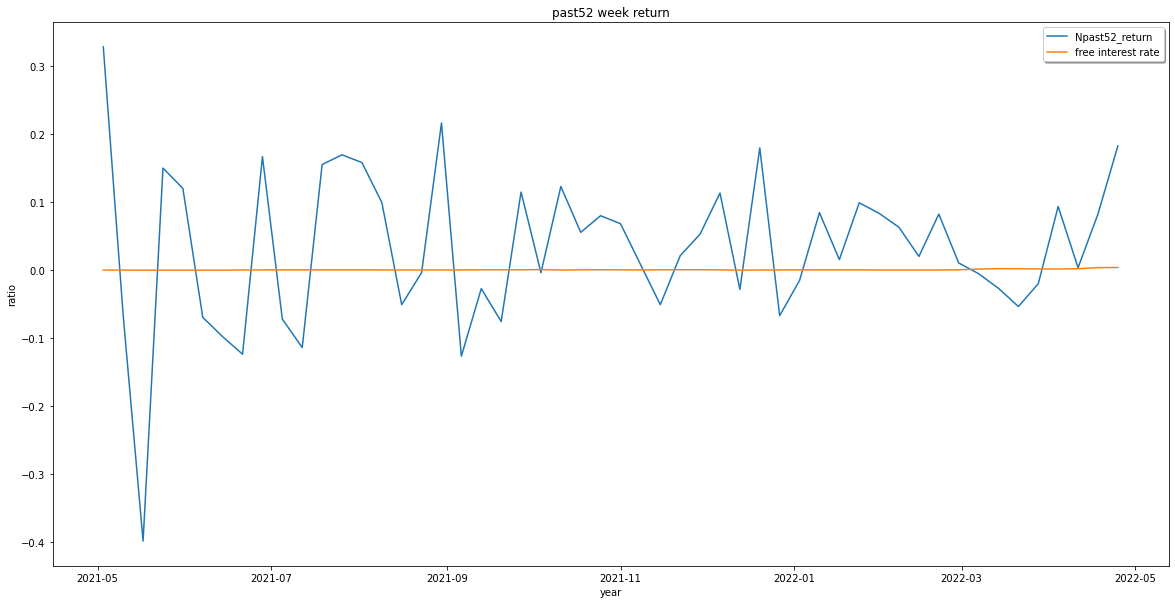

In [37]:
import matplotlib.pyplot as plt

#for i in regr_df.columns.to_list():
plt.figure(figsize = (20,10))
plt.plot(regr_df.Date, regr_df.VAL,label='Npast52_return')
plt.plot(regr_df.Date, regr_df.RiskFree,label='free interest rate')
plt.ylabel('ratio')
plt.xlabel('year')
plt.title('past52 week return')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.show()
